# Configs

## Required packages

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
  !git clone https://github.com/wgova/automations
except:
  pass
else:
  os.chdir('automations')
  !git fetch origin && git pull
  os.chdir('../')

Mounted at /content/drive
fatal: destination path 'automations' already exists and is not an empty directory.
Already up to date.


In [ ]:
# !pip install -q oec
# import oec
!pip install -U -q yellowbrick
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from automations.data_processors import *
from automations.correlation_analysis import *
from automations.feature_selection import *
from automations.clustering_helpers import *

## Load data

## Data processing

### Lists

In [ ]:
# List of features
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_','index_mass_quantile','__attr_intercept','__attr_stderr',
                      'sum_values','sum_values','has_duplicate','length','quantile','ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                      'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks','reversal','value_count','spkt_welch_density','range_count','larger',
                      'variation_coefficient','max_langevin_fixed_point','reoccurring','symmetry_looking','variation','longest_strike_','energy_ratio_by_chunks',
                      'variance_larger_than_standard_deviation','__lag_0','fourier_entropy','friedrich_coefficients','bins_100']
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation','median','sum_values','maximum','length','minimum']
stats = ['kurtosis','^median$','linear_trend']
stationarity = ['correlation','augmented','entropy','energy','komolgorov','lyapunov','complexity','ar_coefficient','cid_ce','sample']

### Data preparation

In [ ]:
experiment = "stationary_entropy"
PATH = '/content/drive/My Drive/Stellenbosch/Webster/all_products'
all_eff_features = pd.read_csv(f'{PATH}/product_features_all_countries.csv')\
.rename(columns = {'Unnamed: 0': 'country_product'}, inplace = False)
all_eff_features.set_index('country_product',inplace=True)
features_filtered = change_column_prefix(
    remove_features_df(all_eff_features,filter_features(all_eff_features,redundant_features)))
features_filtered.head()

,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,mean,standard_deviation,variance,skewness,kurtosis,absolute_sum_of_changes,first_location_of_maximum,first_location_of_minimum,maximum,minimum,benford_correlation,c3__lag_1,c3__lag_2,c3__lag_3,cid_ce__normalize_True,cid_ce__normalize_False,autocorrelation__lag_1,autocorrelation__lag_2,autocorrelation__lag_3,autocorrelation__lag_4,autocorrelation__lag_5,autocorrelation__lag_6,autocorrelation__lag_7,autocorrelation__lag_8,autocorrelation__lag_9,partial_autocorrelation__lag_1,partial_autocorrelation__lag_2,partial_autocorrelation__lag_3,partial_autocorrelation__lag_4,partial_autocorrelation__lag_5,partial_autocorrelation__lag_6,partial_autocorrelation__lag_7,partial_autocorrelation__lag_8,partial_autocorrelation__lag_9,number_peaks__n_1,number_peaks__n_3,number_peaks__n_5,number_peaks__n_10,number_peaks__n_50,binned_entropy__max_bins_10,ar_coefficient__coeff_0__k_10,ar_coefficient__coeff_1__k_10,ar_coefficient__coeff_2__k_10,ar_coefficient__coeff_3__k_10,ar_coefficient__coeff_4__k_10,ar_coefficient__coeff_5__k_10,ar_coefficient__coeff_6__k_10,ar_coefficient__coeff_7__k_10,ar_coefficient__coeff_8__k_10,ar_coefficient__coeff_9__k_10,ar_coefficient__coeff_10__k_10,"linear_trend__attr_""pvalue""","linear_trend__attr_""rvalue""","linear_trend__attr_""intercept""","linear_trend__attr_""slope""","linear_trend__attr_""stderr""","augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",lempel_ziv_complexity__bins_2,lempel_ziv_complexity__bins_3,lempel_ziv_complexity__bins_5,lempel_ziv_complexity__bins_10,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1
country_product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
afago_Cars,1.884682e+16,5.718427e+06,-857.142857,-1.424316e+06,127624.0,3.163427e+06,1.915540e+07,3.669292e+14,6.988313,49.159203,280202900.0,0.960000,0.980000,136717317.0,0.0,0.931227,7.717079e+18,2.384126e+17,2.806983e+18,9.671961,1.852703e+08,0.065299,-0.002642,0.002889,-0.001842,0.000227,0.004997,-0.004486,-0.005217,-0.006445,0.065299,-0.006936,0.003530,-0.002292,0.000531,0.004939,-0.005144,-0.004562,-0.005908,14.0,5.0,2.0,1.0,0.0,0.098039,-1.485219e+06,2.291699,-23.068724,22.731775,-7.542535,6.943434,53.783580,-43.871567,29.883554,-28.947969,7.877567,0.073232,0.255578,-5.148255e+06,339252.339592,185229.185662,1.260785,0.996380,6.0,0.200000,0.220000,0.220000,0.220000,1.757211,2.850623,3.515898,3.745049,3.784190
afago_Electrical Resistors,4.470029e+07,7.925385e+02,0.000000,-1.122000e+01,0.0,4.841111e+02,1.192142e+03,1.421203e+06,3.523090,13.916438,20606.0,0.370370,0.000000,5734.0,0.0,0.852450,2.024227e+08,1.237606e+08,6.628509e+06,7.447968,8.879036e+03,-0.034654,0.168708,-0.162332,-0.136768,-0.171632,-0.160972,-0.171041,-0.189236,-0.097401,-0.034654,0.167708,-0.156230,-0.179664,-0.135707,-0.157732,-0.212243,-0.291425,-0.275573,6.0,2.0,1.0,1.0,0.0,0.655142,4.108861e+03,-0.769207,-0.536583,-0.606577,-0.627488,-0.607488,-0.588077,-0.577258,-0.586380,-0.620872,-0.576806,0.444244,0.153625,1.784365e+02,23.513431,30.247999,-5.546925,0.000002,9.0,0.370370,0.407407,0.444444,0.444444,1.231831,1.704551,2.074097,2.271869,2.466577
afago_Electrical Transformers,5.848347e+12,2.042586e+05,0.000000,-4.784538e+03,2793.0,1.274670e+05,4.388869e+05,1.926217e+11,4.975782,25.577179,5514982.0,0.821429,0.000000,2362467.0,0.0,0.732798,7.766177e+15,2.939491e+14,3.676756e+15,7.096393,3.114514e+06,0.101343,0.032008,0.097726,-0.077503,0.051330,-0.013735,-0.027257,-0.028950,-0.045893,0.101343,0.021963,0.093331,-0.098766,0.066852,-0.033446,-0.006459,-0.046059,-0.022475,9.0,3.0,1.0,0.0,0.0,0.408698,-5.445308e+04,0.075168,-0.670220,0.283833,0.117824,15.988711,1.862370,-2.781384,-4.31280

# Run the ETL

In [ ]:
features_filtered = change_column_prefix(
    remove_features_df(
        all_eff_features,filter_features(all_eff_features,redundant_features)))
# get exclude list for stationary features
# call stationary feature list on filtered feature dataframe
stationary_features_df = features_filtered[filter_features(features_filtered,stationarity)]
stationary_features_df.head()

,benford_correlation,autocorrelation__lag_1,autocorrelation__lag_2,autocorrelation__lag_3,autocorrelation__lag_4,autocorrelation__lag_5,autocorrelation__lag_6,autocorrelation__lag_7,autocorrelation__lag_8,autocorrelation__lag_9,partial_autocorrelation__lag_1,partial_autocorrelation__lag_2,partial_autocorrelation__lag_3,partial_autocorrelation__lag_4,partial_autocorrelation__lag_5,partial_autocorrelation__lag_6,partial_autocorrelation__lag_7,partial_autocorrelation__lag_8,partial_autocorrelation__lag_9,"augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",binned_entropy__max_bins_10,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,abs_energy,lempel_ziv_complexity__bins_2,lempel_ziv_complexity__bins_3,lempel_ziv_complexity__bins_5,lempel_ziv_complexity__bins_10,ar_coefficient__coeff_0__k_10,ar_coefficient__coeff_1__k_10,ar_coefficient__coeff_2__k_10,ar_coefficient__coeff_3__k_10,ar_coefficient__coeff_4__k_10,ar_coefficient__coeff_5__k_10,ar_coefficient__coeff_6__k_10,ar_coefficient__coeff_7__k_10,ar_coefficient__coeff_8__k_10,ar_coefficient__coeff_9__k_10,ar_coefficient__coeff_10__k_10,cid_ce__normalize_True,cid_ce__normalize_False
country_product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
afago_Cars,0.931227,0.065299,-0.002642,0.002889,-0.001842,0.000227,0.004997,-0.004486,-0.005217,-0.006445,0.065299,-0.006936,0.003530,-0.002292,0.000531,0.004939,-0.005144,-0.004562,-0.005908,1.260785,0.996380,6.0,0.098039,1.757211,2.850623,3.515898,3.745049,3.784190,1.884682e+16,0.200000,0.220000,0.220000,0.220000,-1.485219e+06,2.291699,-23.068724,22.731775,-7.542535,6.943434,53.783580,-43.871567,29.883554,-28.947969,7.877567,9.671961,1.852703e+08
afago_Electrical Resistors,0.852450,-0.034654,0.168708,-0.162332,-0.136768,-0.171632,-0.160972,-0.171041,-0.189236,-0.097401,-0.034654,0.167708,-0.156230,-0.179664,-0.135707,-0.157732,-0.212243,-0.291425,-0.275573,-5.546925,0.000002,9.0,0.655142,1.231831,1.704551,2.074097,2.271869,2.466577,4.470029e+07,0.370370,0.407407,0.444444,0.444444,4.108861e+03,-0.769207,-0.536583,-0.606577,-0.627488,-0.607488,-0.588077,-0.577258,-0.586380,-0.620872,-0.576806,7.447968,8.879036e+03
afago_Electrical Transformers,0.732798,0.101343,0.032008,0.097726,-0.077503,0.051330,-0.013735,-0.027257,-0.028950,-0.045893,0.101343,0.021963,0.093331,-0.098766,0.066852,-0.033446,-0.006459,-0.046059,-0.022475,10.007908,1.000000,4.0,0.408698,1.758797,2.622498,2.947005,3.075221,3.091042,5.848347e+12,0.321429,0.321429,0.321429,0.357143,-5.445308e+04,0.075168,-0.670220,0.283833,0.117824,15.988711,1.862370,-2.781384,-4.312806,-0.853757,6.501106,7.096393,3.114514e+06
afago_Electronic Microcircuits,0.837781,0.179572,-0.042137,-0.005413,-0.037120,-0.043936,-0.013451,-0.022264,0.174080,0.000531,0.179572,-0.076862,0.017190,-0.044223,-0.029281,-0.004419,-0.024036,0.188840,-0.080641,-4.110985,0.000929,0.0,0.573516,1.614259,2.301092,2.894400,3.091042,3.044522,7.939345e+11,0.407407,0.407407,0.444444,0.481481,-8.546160e+04,-0.046520,0.106502,1.086189,0.503386,0.445456,0.802596,1.008096,3.824687,1.398958,-0.733413,6.666688,1.084634e+06
afago_Felt,-0.241690,-0.039781,-0.042735,-0.045926,-0.049383,-0.053140,-0.057239,-0.061728,-0.066667,-0.017544,-0.039781,-0.044388,-0.049643,-0.055686,-0.062700,-0.070932,-0.080726,-0.092574,-0.050782,-5.196152,0.000009,0.0,0.154076,0.324508,0.498758,0.681610,0.873464,1.074614,4.900000e+01,0.250000,0.250000,0.250000,0.250000,7.000000e-01,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,0.000000,0.000000,7.620635,9.899495e+00


In [ ]:
# stationary_features_df = remove_outliers_iqr(stationary_features_df)
simplify_column_name(stationary_features_df,'autocorrelation__','auto_corr_')
simplify_column_name(stationary_features_df,'partial_autocorrelation__','pac_')
simplify_column_name(stationary_features_df,'augmented_dickey_fuller__attr_','adf_')
stationary_features_df.columns = (stationary_features_df.columns.str.strip().\
                                  str.replace('__tau_1','').\
                                  str.replace('coefficient__','').\
                                  str.replace('complexity__','').\
                                  str.replace('__k_10','').\
                                  str.replace('__max_bins_10','').\
                                  str.replace('__autolag','')
                                  )
simplify_column_name(stationary_features_df,'permutation_entropy__dimension','permutation_entropy')
clean_header(stationary_features_df)
# Drop correlated features (threshold: 0.5)
# stationarity_uncorrelated = remove_features_df(stationary_features_df,drop_correlated_pairs(stationary_features_df,0.5))
stationary_features_df.columns

Index(['benford_correlation', 'auto_corr_lag_1', 'auto_corr_lag_2',
       'auto_corr_lag_3', 'auto_corr_lag_4', 'auto_corr_lag_5',
       'auto_corr_lag_6', 'auto_corr_lag_7', 'auto_corr_lag_8',
       'auto_corr_lag_9', 'pac_lag_1', 'pac_lag_2', 'pac_lag_3', 'pac_lag_4',
       'pac_lag_5', 'pac_lag_6', 'pac_lag_7', 'pac_lag_8', 'pac_lag_9',
       'adf_teststat_aic', 'adf_pvalue_aic', 'adf_usedlag_aic',
       'binned_entropy', 'permutation_entropy_3', 'permutation_entropy_4',
       'permutation_entropy_5', 'permutation_entropy_6',
       'permutation_entropy_7', 'abs_energy', 'lempel_ziv_bins_2',
       'lempel_ziv_bins_3', 'lempel_ziv_bins_5', 'lempel_ziv_bins_10',
       'ar_coeff_0', 'ar_coeff_1', 'ar_coeff_2', 'ar_coeff_3', 'ar_coeff_4',
       'ar_coeff_5', 'ar_coeff_6', 'ar_coeff_7', 'ar_coeff_8', 'ar_coeff_9',
       'ar_coeff_10', 'cid_ce__normalize_true', 'cid_ce__normalize_false'],
      dtype='object')

In [ ]:
features = ['auto_corr_lag_1', 'auto_corr_lag_2',
       'auto_corr_lag_3', 'pac_lag_1', 'pac_lag_2', 'pac_lag_3', 
       'adf_teststat_aic', 'adf_pvalue_aic','binned_entropy',
       'permutation_entropy_7', 'abs_energy', 'lempel_ziv_bins_3',
       'lempel_ziv_bins_5', 'lempel_ziv_bins_10',
       'ar_coeff_1', 'ar_coeff_2', 'ar_coeff_3']
stationary_features_df = stationary_features_df[features]
stationary_features_df = remove_outliers_iqr(stationary_features_df)
stationary_features_df.reset_index() 

,country_product,auto_corr_lag_1,auto_corr_lag_2,auto_corr_lag_3,pac_lag_1,pac_lag_2,pac_lag_3,adf_teststat_aic,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,lempel_ziv_bins_3,lempel_ziv_bins_5,lempel_ziv_bins_10,ar_coeff_1,ar_coeff_2,ar_coeff_3
0,afago_Cars,0.065299,-0.002642,0.002889,0.065299,-0.006936,0.003530,1.260785,0.996380,0.098039,3.784190,1.884682e+16,0.220000,0.220000,0.220000,2.291699,-23.068724,22.731775
1,afago_Electrical Resistors,-0.034654,0.168708,-0.162332,-0.034654,0.167708,-0.156230,-5.546925,0.000002,0.655142,2.466577,4.470029e+07,0.407407,0.444444,0.444444,-0.769207,-0.536583,-0.606577
2,afago_Electrical Transformers,0.101343,0.032008,0.097726,0.101343,0.021963,0.093331,10.007908,1.000000,0.408698,3.091042,5.848347e+12,0.321429,0.321429,0.357143,0.075168,-0.670220,0.283833
3,afago_Electronic Microcircuits,0.179572,-0.042137,-0.005413,0.179572,-0.076862,0.017190,-4.110985,0.000929,0.573516,3.044522,7.939345e+11,0.407407,0.444444,0.481481,-0.046520,0.106502,1.086189
4,afago_Felt,-0.039781,-0.042735,-0.045926,-0.039781,-0.044388,-0.049643,-5.196152,0.000009,0.154076,1.074614,4.900000e+01,0.250000,0.250000,0.250000,-0.100000,-0.100000,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,saven_non_medicinals,0.949631,0.875753,0.817281,0.949631,-0.265238,0.185497,-1.240616,0.655884,1.466929,3.775856,9.256238e+13,0.274510,0.333333,0.431373,1.148799,-0.441133,0.340321
3952,saven_pharma_flora,0.499992,0.440558,0.415056,0.499992,0.254084,0.176326,-2.464631,0.124319,1.555331,3.828641,7.737970e+12,0.230769,0.346154,0.442308,0.284788,0.254513,0.106313
3953,saven_synthetic_fiber,0.693870,0.531949,0.156916,0.693870,0.097375,-0.474686,-2.598548,0.093298,1.898927,3.178054,2.809619e+13,0.433333,0.500000,0.566667,0.549630,0.480889,-0.898211
3954,saven_vehicle_parts,0.895675,0.752532,0.584610,0.895675,-0.251309,-0.181952,-3.961479,0.001626,1.936607,2.945784,4.900160e+17,0.323529,0.441176,0.558824,0.819523,-0.148107,0.043393


In [ ]:
# Add statistical features to dataframe
stats_features_df = features_filtered[filter_features(features_filtered,stats)]
stats_features_df = remove_outliers_iqr(stats_features_df)
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('__autolag_aic', ''))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('kurtosis', 'kurtosis'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('median','median'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('linear_trend__attr', 'trend'))
stats_features_df.reset_index() 

,country_product,kurtosis,median,"trend_""pvalue""","trend_""rvalue""","trend_""intercept""","trend_""slope""","trend_""stderr"""
0,afago_Cars,49.159203,127624.0,7.323154e-02,0.255578,-5.148255e+06,3.392523e+05,1.852292e+05
1,afago_Electrical Resistors,13.916438,0.0,4.442436e-01,0.153625,1.784365e+02,2.351343e+01,3.024800e+01
2,afago_Electrical Transformers,25.577179,2793.0,8.650862e-02,0.329838,-1.144669e+05,1.792103e+04,1.005923e+04
3,afago_Electronic Microcircuits,20.327130,2035.0,5.554473e-02,0.372699,-4.702466e+04,7.784951e+03,3.876626e+03
4,afago_Felt,28.000000,0.0,5.062810e-01,0.131036,-3.448276e-02,2.107280e-02,3.126685e-02
...,...,...,...,...,...,...,...,...
3951,saven_non_medicinals,-1.370342,170000.0,1.420075e-08,0.696082,-3.138295e+05,4.799281e+04,7.071635e+03
3952,saven_pharma_flora,5.368991,252767.0,2.308626e-03,0.413551,1.161803e+05,6.922997e+03,2.155514e+03
3953,saven_synthetic_fiber,-0.678469,409056.0,4.896183e-02,0.362544,2.726271e+05,2.856004e+04,1.387458e+04
3954,saven_vehicle_parts,-1.316080,60387342.0,2.635882e-02,0.380649,3.742017e+07,3.126018e+06,1.342460e+06


In [ ]:
# Merge stationarity and statistical features
features_uncorrelated = pd.merge(stationary_features_df,stats_features_df,on='country_product')
clean_header(features_uncorrelated)

,auto_corr_lag_1,auto_corr_lag_2,auto_corr_lag_3,pac_lag_1,pac_lag_2,pac_lag_3,adf_teststat_aic,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,lempel_ziv_bins_3,lempel_ziv_bins_5,lempel_ziv_bins_10,ar_coeff_1,ar_coeff_2,ar_coeff_3,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr
country_product,,,,,,,,,,,,,,,,,,,,,,,,
afago_Cars,0.065299,-0.002642,0.002889,0.065299,-0.006936,0.003530,1.260785,0.996380,0.098039,3.784190,1.884682e+16,0.220000,0.220000,0.220000,2.291699,-23.068724,22.731775,49.159203,127624.0,7.323154e-02,0.255578,-5.148255e+06,3.392523e+05,1.852292e+05
afago_Electrical Resistors,-0.034654,0.168708,-0.162332,-0.034654,0.167708,-0.156230,-5.546925,0.000002,0.655142,2.466577,4.470029e+07,0.407407,0.444444,0.444444,-0.769207,-0.536583,-0.606577,13.916438,0.0,4.442436e-01,0.153625,1.784365e+02,2.351343e+01,3.024800e+01
afago_Electrical Transformers,0.101343,0.032008,0.097726,0.101343,0.021963,0.093331,10.007908,1.000000,0.408698,3.091042,5.848347e+12,0.321429,0.321429,0.357143,0.075168,-0.670220,0.283833,25.577179,2793.0,8.650862e-02,0.329838,-1.144669e+05,1.792103e+04,1.005923e+04
afago_Electronic Microcircuits,0.179572,-0.042137,-0.005413,0.179572,-0.076862,0.017190,-4.110985,0.000929,0.573516,3.044522,7.939345e+11,0.407407,0.444444,0.481481,-0.046520,0.106502,1.086189,20.327130,2035.0,5.554473e-02,0.372699,-4.702466e+04,7.784951e+03,3.876626e+03
afago_Felt,-0.039781,-0.042735,-0.045926,-0.039781,-0.044388,-0.049643,-5.196152,0.000009,0.154076,1.074614,4.900000e+01,0.250000,0.250000,0.250000,-0.100000,-0.100000,-0.100000,28.000000,0.0,5.062810e-01,0.131036,-3.448276e-02,2.107280e-02,3.126685e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
saven_non_medicinals,0.949631,0.875753,0.817281,0.949631,-0.265238,0.185497,-1.240616,0.655884,1.466929,3.775856,9.256238e+13,0.274510,0.333333,0.431373,1.148799,-0.441133,0.340321,-1.370342,170000.0,1.420075e-08,0.696082,-3.138295e+05,4.799281e+04,7.071635e+03
saven_pharma_flora,0.499992,0.440558,0.415056,0.499992,0.254084,0.176326,-2.464631,0.124319,1.555331,3.828641,7.737970e+12,0.230769,0.346154,0.442308,0.284788,0.254513,0.106313,5.368991,252767.0,2.308626e-03,0.413551,1.161803e+05,6.922997e+03,2.155514e+03
saven_synthetic_fiber,0.693870,0.531949,0.156916,0.693870,0.097375,-0.474686,-2.598548,0.093298,1.898927,3.178054,2.809619e+13,0.433333,0.500000,0.566667,0.549630,0.480889,-0.898211,-0.678469,409056.0,4.896183e-02,0.362544,2.726271e+05,2.856004e+04,1.387458e+04


In [ ]:
features_uncorrelated.fillna(0,inplace=True)
features_uncorrelated.isnull().sum()

auto_corr_lag_1          0
auto_corr_lag_2          0
auto_corr_lag_3          0
pac_lag_1                0
pac_lag_2                0
pac_lag_3                0
adf_teststat_aic         0
adf_pvalue_aic           0
binned_entropy           0
permutation_entropy_7    0
abs_energy               0
lempel_ziv_bins_3        0
lempel_ziv_bins_5        0
lempel_ziv_bins_10       0
ar_coeff_1               0
ar_coeff_2               0
ar_coeff_3               0
kurtosis                 0
median                   0
trend_pvalue             0
trend_rvalue             0
trend_intercept          0
trend_slope              0
trend_stderr             0
dtype: int64

## EDA and correlation analysis

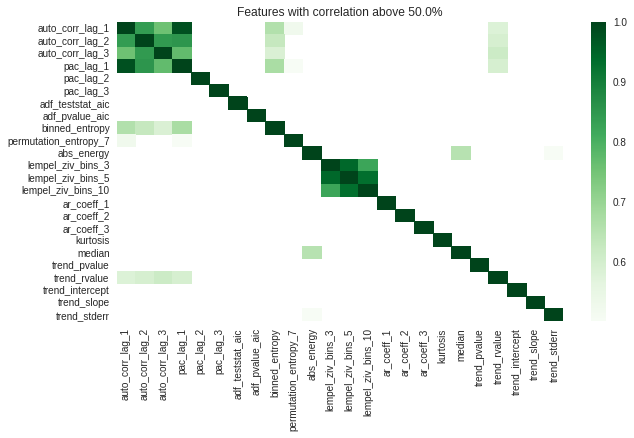

In [ ]:
image_dump = f"{PATH}/images"
# Check if all features are not correlated
plot_correlated_features(features_uncorrelated,0.5)
plt.savefig(f"{image_dump}/_correlation_{experiment}")
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series

# Clustering

## PCA + k-Means

* Scale features using Standard Scaler
* Dimension reduction to 2 PCs
* Locate optimum number of cluster

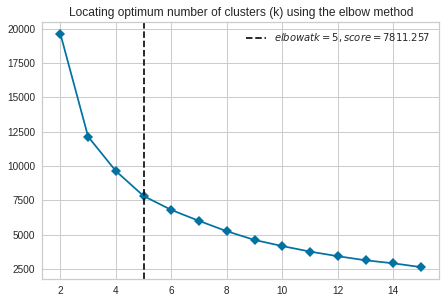

In [ ]:
features_uncorrelated = scale_features(features_uncorrelated)
X_scaled_transposed = np.asarray(features_uncorrelated)
product_name = 'all_products'
# Reduce dimensions using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_uncorrelated)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
# Plot the explained variances
features = range(pca.n_components_)

# Optimum clusters
# plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}_pca_kmeans",np.asarray(PCA_components),15)
kelbow_visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=15,metric='distortion',
    timings=False,locate_elbow=True,size=(512, 340))
kelbow_visualizer.fit(np.asarray(PCA_components))
pca_k_value = kelbow_visualizer.elbow_value_
plt.title('Locating optimum number of clusters (k) using the elbow method')
plt.legend()
plt.savefig(f"{image_dump}/{experiment}_elbow")

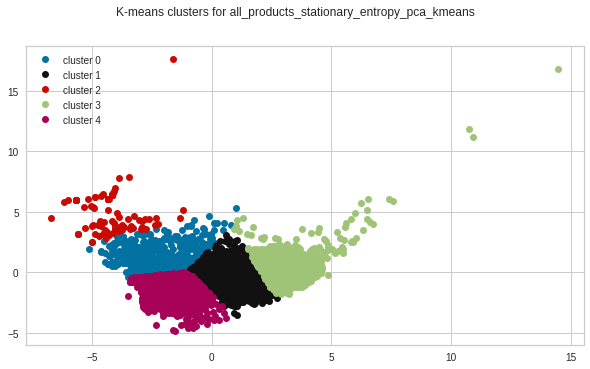

In [ ]:
clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),pca_k_value,f"{product_name}_{experiment}_pca_kmeans",f"{image_dump}")

details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'country_product':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')

In [ ]:
groups = country_cluster.groupby(['cluster']).agg('mean')

In [ ]:
clust = groups.reset_index()
dict_clust = {0:'cluster_0',
              1: 'cluster_1',
              2: 'cluster_2',
              3: 'cluster_3',
              4: 'cluster_4',
              5: 'cluster_5'
              }
clust = groups.reset_index()
clust.replace({'cluster': dict_clust},inplace=True)
clust.set_index('cluster',inplace=True)
# x = clust.iloc[-1,:]

In [ ]:
b = clust.T
b.head()

cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
auto_corr_lag_1,-0.790704,0.296535,-1.284506,1.275521,-0.753554
auto_corr_lag_2,-0.826473,0.106487,-1.162715,1.372213,-0.680716
auto_corr_lag_3,-0.826509,0.003224,-1.011335,1.374022,-0.619281
pac_lag_1,-0.827184,0.289965,-0.954432,1.301905,-0.795471
pac_lag_2,-0.340672,0.173522,-0.158887,0.025222,0.022359


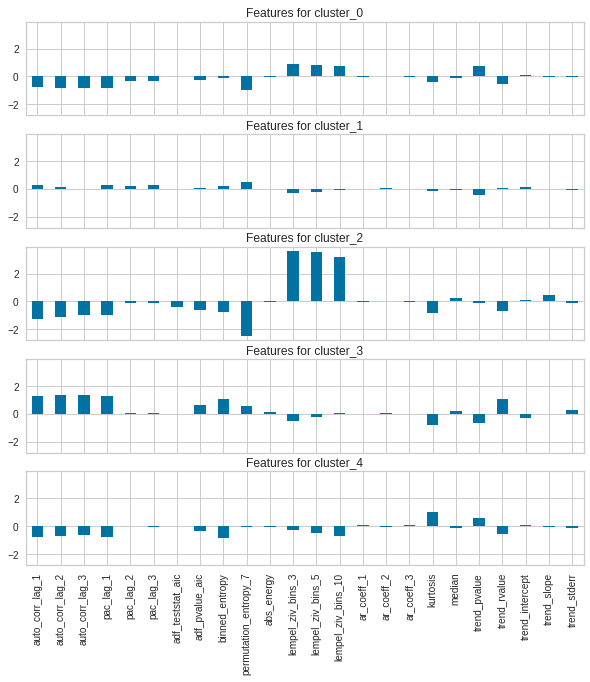

In [ ]:
n = len(b.columns)
fig, ax = plt.subplots(n, 1, figsize=(10, n * 2), sharex=True,sharey=True)
for i in range(n):
    plt.sca(ax[i])
    col = b.columns[i]
    b[col].plot(kind='bar')
    plt.title(f"Features for {col}")
    # plt.tight_layout()
fig.savefig(f"{image_dump}/{product_name}_{experiment}_pca_kmeans_features.png",bbox_inches = "tight")

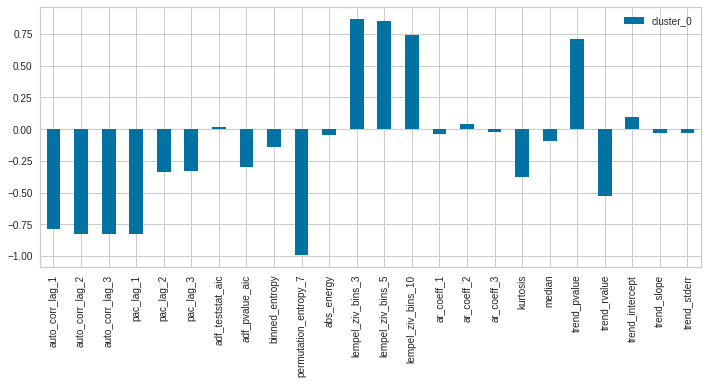

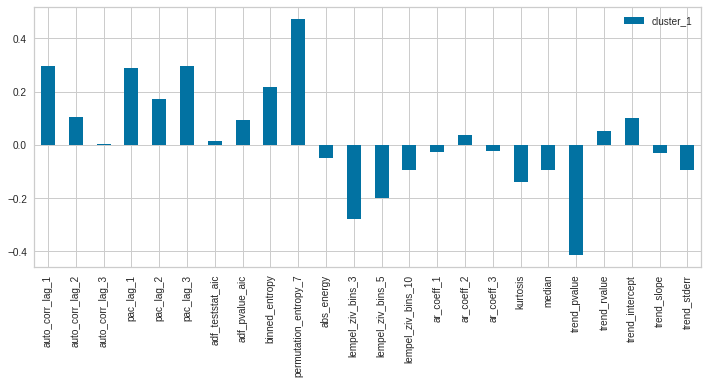

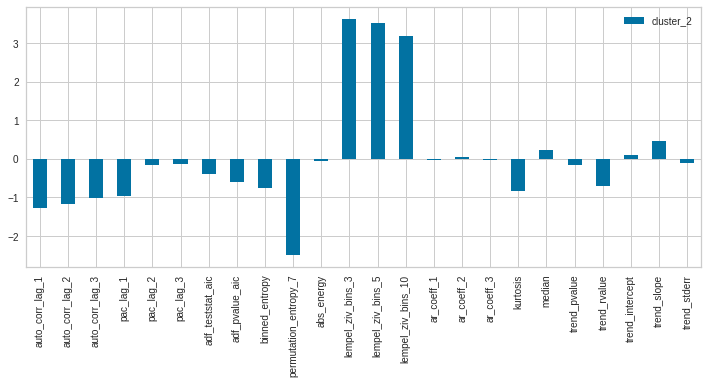

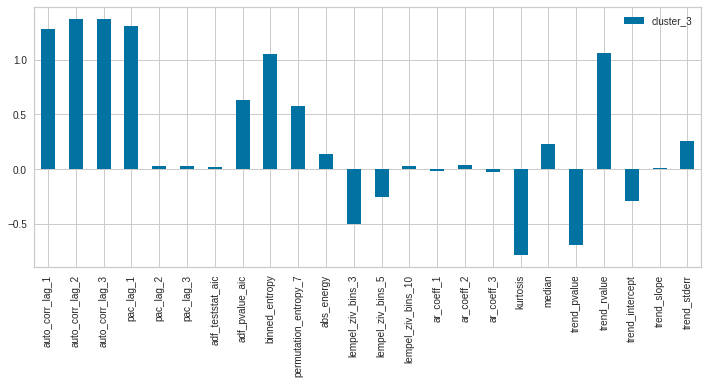

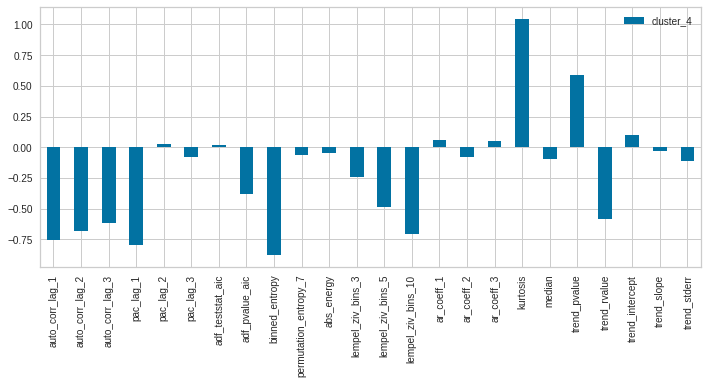

In [ ]:
for col in b.columns:
  b[col].plot(kind='bar',figsize=(10,5.5))
  plt.legend()
  plt.tight_layout()
  plt.savefig(f"{image_dump}/{col}_{product_name}_features.png",bbox_inches = "tight")
  plt.show()

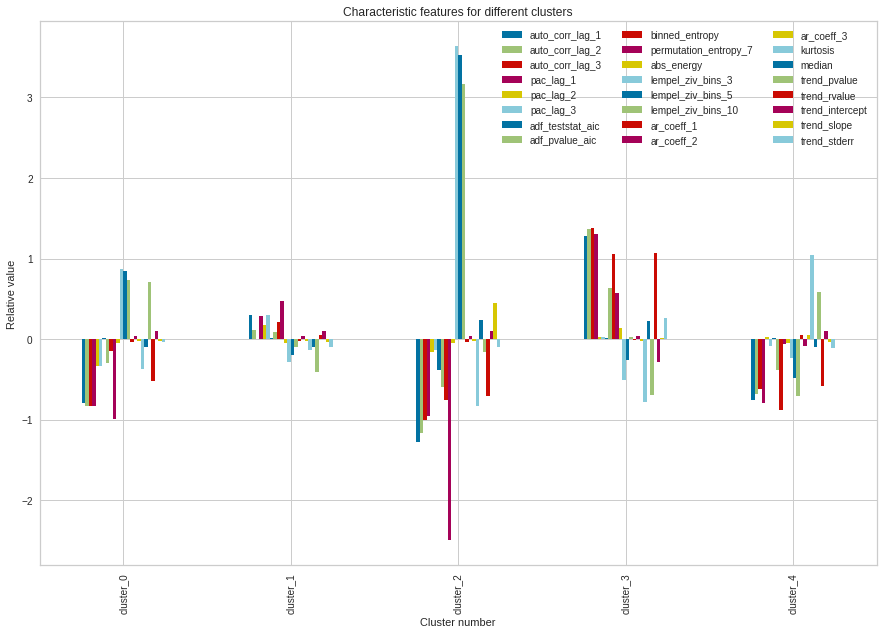

In [ ]:
# clusts.shape[0]
ax = clust.plot(figsize=(15,10),kind='bar')
fig = ax.get_figure()
plt.xlabel('Cluster number')
plt.ylabel("Relative value")
plt.legend(loc='best',ncol=3)
plt.title('Characteristic features for different clusters')
fig.savefig(f"{image_dump}/{product_name}_{experiment}_pca_kmeans_features.png")

# Cluster analysis

In [ ]:
trade_dframe = pd.read_csv(f"{PATH}/trade_data_flat_df.csv",
                           usecols=['year','export_val','country','product_name','country_product']
                           )
trade_dframe.head()

,year,export_val,country,product_name,country_product
0,1962,3000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
1,1963,15000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
2,1964,4000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
3,1966,2000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
4,1967,7000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber


In [ ]:
country_cluster.head()

,names,auto_corr_lag_1,auto_corr_lag_2,auto_corr_lag_3,pac_lag_1,pac_lag_2,pac_lag_3,adf_teststat_aic,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,lempel_ziv_bins_3,lempel_ziv_bins_5,lempel_ziv_bins_10,ar_coeff_1,ar_coeff_2,ar_coeff_3,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,cluster
0,afago_Cars,-0.699309,-0.679260,-0.544710,-0.739400,0.141456,0.009284,0.016423,1.446917,-1.526053,1.038662,-0.049445,-1.204692,-1.546453,-1.909458,0.028511,-0.109969,-0.022255,4.196947,-0.097398,-0.486480,-0.170293,0.092860,-0.031036,-0.102641,4
1,afago_Electrical Resistors,-0.949355,-0.215017,-1.029699,-0.997863,0.932888,-0.714529,0.016423,-0.891944,-0.586474,-0.210139,-0.049449,0.152629,0.100074,-0.306037,-0.058897,0.033928,-0.024509,0.557114,-0.097494,0.728612,-0.434640,0.097811,-0.031327,-0.117015,4
2,afago_Electrical Transformers,-0.609143,-0.585381,-0.266324,-0.646198,0.272417,0.416133,0.016423,1.455414,-1.002113,0.381714,-0.049449,-0.470083,-0.802372,-0.929715,-0.034785,0.033074,-0.024423,1.761422,-0.097492,-0.442996,0.022249,0.097701,-0.031312,-0.116236,4
3,afago_Electronic Microcircuits,-0.413443,-0.786265,-0.569079,-0.443912,-0.175428,0.071169,0.016423,-0.889767,-0.724140,0.337623,-0.049449,0.152629,0.100074,-0.041446,-0.038260,0.038035,-0.024346,1.219203,-0.097492,-0.544405,0.133379,0.097766,-0.031320,-0.116716,4
4,afago_Felt,-0.962178,-0.787885,-0.688000,-1.011118,-0.028266,-0.231626,0.016423,-0.891927,-1.431544,-1.529407,-0.049449,-0.987413,-1.326373,-1.695139,-0.039787,0.036716,-0.024461,2.011648,-0.097494,0.931789,-0.493211,0.097811,-0.031327,-0.117017,4


<Figure size 720x396 with 0 Axes>

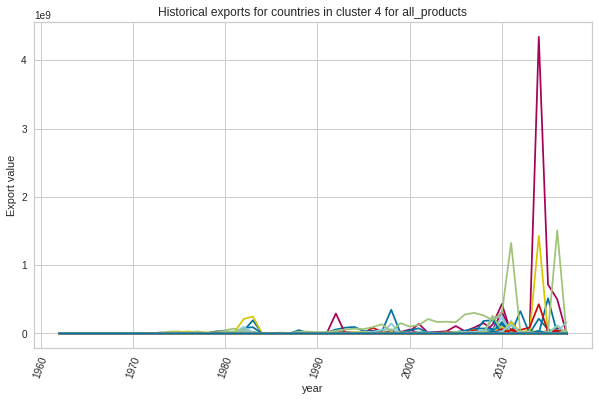

<Figure size 720x396 with 0 Axes>

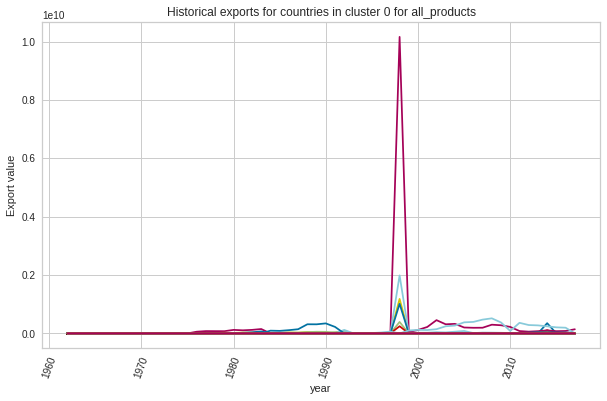

<Figure size 720x396 with 0 Axes>

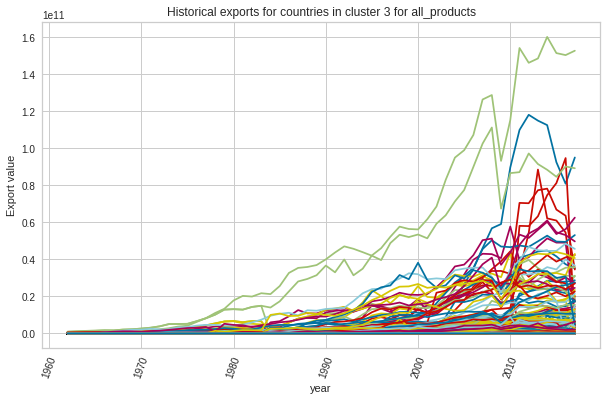

<Figure size 720x396 with 0 Axes>

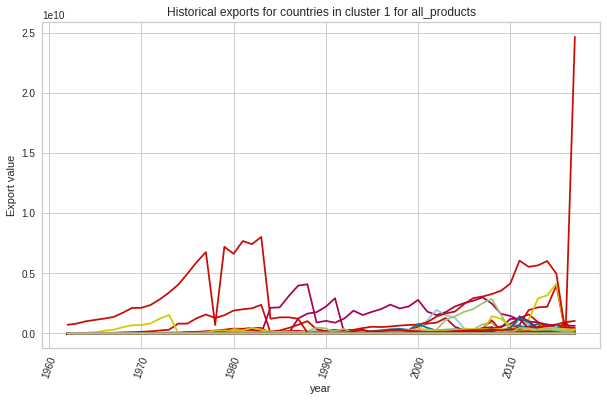

<Figure size 720x396 with 0 Axes>

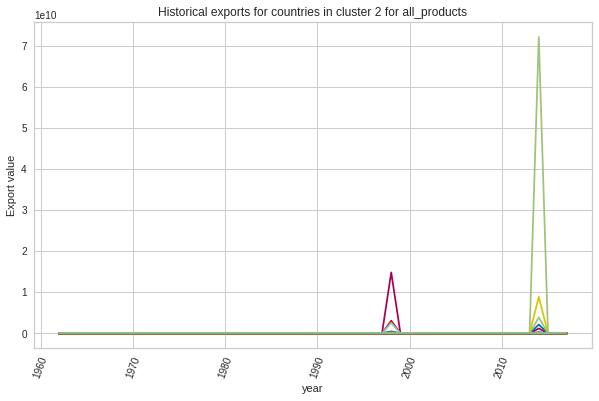

In [ ]:
# Plots for country comparison per product 
for c in country_cluster.cluster.unique():
  cluster = country_cluster[country_cluster.cluster==c]
  country_list = cluster['names'].unique()
  product = pd.pivot_table(trade_dframe,index='year',columns='country_product',
                           values='export_val',aggfunc=np.mean)
  df = product[country_list]
  df.fillna(0,inplace=True)
  plt.figure(figsize=(10,5.5))
  df.plot(subplots=False,figsize=(10,6),legend=False,
                            title=(f"Historical exports for countries in cluster {c} for {product_name}"))
  plt.xticks(rotation=70)
  # plt.legend()
  plt.ylabel("Export value")
  plt.savefig(f"{image_dump}/{product_name}_cluster_{c}")
  plt.show()